In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, r2_score, precision_score, recall_score, roc_curve, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [2]:
dataset = np.load("processed_dataset.npz")
X_train = dataset['X_train']
Y_train = dataset['Y_train']
X_test = dataset['X_test']
Y_test = dataset['Y_test']

X_train = X_train[:, :3]
X_test = X_test[:, :3]

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

scaler = MinMaxScaler()
Y_train = scaler.fit_transform(Y_train)
Y_test = scaler.transform(Y_test)

(148, 3) (148, 3) (7, 3) (7, 3)


In [3]:
# Convert to classification labels by checking if Y[:2] is greater than 0.5
Y_train = (Y_train[:, 2] > 0.5).astype(int)
Y_test = (Y_test[:, 2] > 0.5).astype(int)

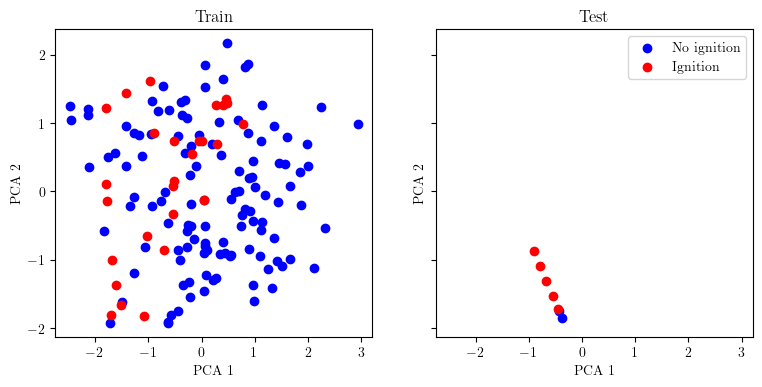

In [4]:
# Plot PCA of the dataset
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
ax = axs[0]
ax.set_title("Train")
ax.scatter(X_train_pca[Y_train == 0, 0], X_train_pca[Y_train == 0, 1], c='b', label='No ignition')
ax.scatter(X_train_pca[Y_train == 1, 0], X_train_pca[Y_train == 1, 1], c='r', label='Ignition')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax = axs[1]
ax.set_title("Test")
ax.scatter(X_test_pca[Y_test == 0, 0], X_test_pca[Y_test == 0, 1], c='b', label='No ignition')
ax.scatter(X_test_pca[Y_test == 1, 0], X_test_pca[Y_test == 1, 1], c='r', label='Ignition')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend()
plt.show()


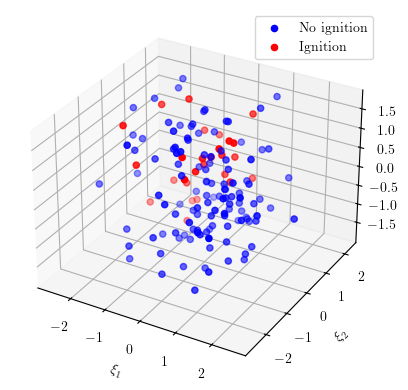

In [5]:
# 3d scatter plot of dataset

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_train[Y_train == 0, 0], X_train[Y_train == 0, 1], X_train[Y_train == 0, 2], c='b', label='No ignition')
ax.scatter(X_train[Y_train == 1, 0], X_train[Y_train == 1, 1], X_train[Y_train == 1, 2], c='r', label='Ignition')
ax.set_xlabel(r"$\xi_1$")
ax.set_ylabel(r"$\xi_2$")
ax.set_zlabel(r"$\xi_3$")
ax.legend()
plt.show()

<BarContainer object of 2 artists>

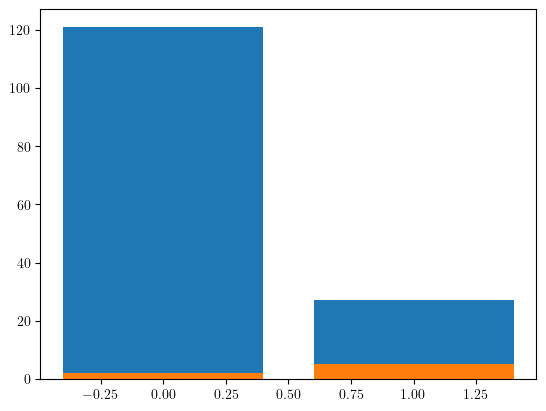

In [6]:
# Plot the class distribution
plt.bar([0, 1], [np.sum(Y_train == 0), np.sum(Y_train == 1)])
plt.bar([0, 1], [np.sum(Y_test == 0), np.sum(Y_test == 1)])

IndexError: index 3 is out of bounds for axis 1 with size 3

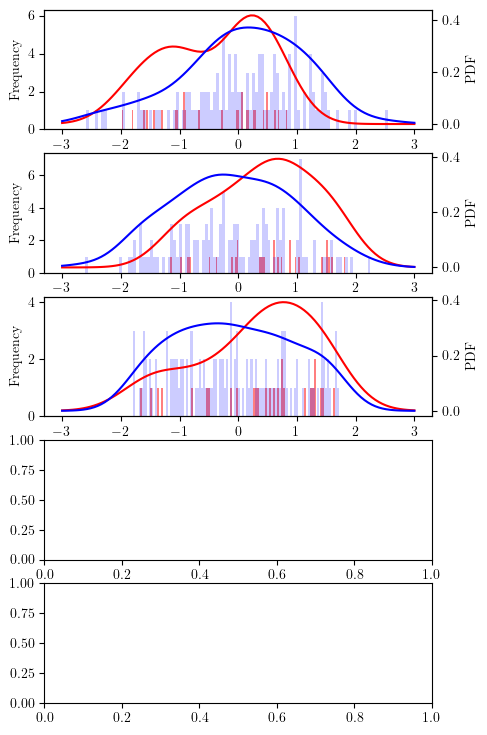

In [7]:
from scipy.stats import gaussian_kde

# Plot the empirical distribution of P(X|ignition) for each feature

X_ignition = X_train[Y_train == 1, :]
X_noignition = X_train[Y_train == 0, :]

fig, axs = plt.subplots(5, 1, figsize=(5, 9))
for i in range(5):
    ax = axs[i]
    ax.hist(X_ignition[:, i], bins=100, density=0, alpha=0.5, facecolor='red')
    ax.hist(X_noignition[:, i], bins=100, density=0, alpha=0.2, facecolor='blue')
    ax.set_ylabel("Frequency")
    ax.set_xlabel(rf"$\xi_{i}$")
    
    # Plot KDE line
    x = np.linspace(-3, 3, 100)
    kde = gaussian_kde(X_ignition[:, i])
    ax = ax.twinx()
    ax.set_ylabel("PDF")
    ax.plot(x, kde(x), color="red", label="ignition")
    
    kde = gaussian_kde(X_noignition[:, i])
    ax.plot(x, kde(x), color="blue", label="no ignition")
    
    if i==4:
        ax.legend()

fig.tight_layout()
plt.show()


In [33]:
from scipy.stats import loguniform, uniform
from sklearn.model_selection import RandomizedSearchCV

# Automatically find the best model using randomised search over hyper-params using CV

lr = LogisticRegression()

param_grid = {
    'class_weight': ['balanced'], # 'balanced' is useful for imbalanced datasets
    'C': loguniform(0.001, 1000),
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100, 5000)),
    'solver': ['liblinear', 'newton-cg', 'sag']
}

grid_search = RandomizedSearchCV(lr, param_distributions=param_grid, n_iter=10000, cv=5, n_jobs=10, scoring='roc_auc')

grid_search.fit(X_train, Y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)
lr = grid_search.best_estimator_

/Users/murray/miniconda/miniconda3/envs/dmd/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/murray/miniconda/miniconda3/envs/dmd/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


{'C': 0.0573035255756774, 'class_weight': 'balanced', 'max_iter': 3145, 'penalty': 'l2', 'solver': 'sag'}
0.7107222222222223


/Users/murray/miniconda/miniconda3/envs/dmd/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
16900 fits failed out of a total of 50000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
8625 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/murray/miniconda/miniconda3/envs/dmd/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/murray/miniconda/miniconda3/envs/dmd/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/murray

In [34]:
Y_train_pred = lr.predict(X_train)
Y_test_pred = lr.predict(X_test)

0.4534000615594219
Train accuracy:  0.6824324324324325
Test accuracy:  0.5714285714285714
Train precision:  0.3333333333333333
Test precision:  1.0
Train recall:  0.7407407407407407
Test recall:  0.4
Train R2:  -1.1291704928068564
Test R2:  -1.1
Train AUC:  0.7431894704621977
Test AUC:  1.0
[1 1 1 1 1 0 0] [0.53170239 0.50451299 0.47729687 0.45021489 0.42608636 0.42342478
 0.41018671]


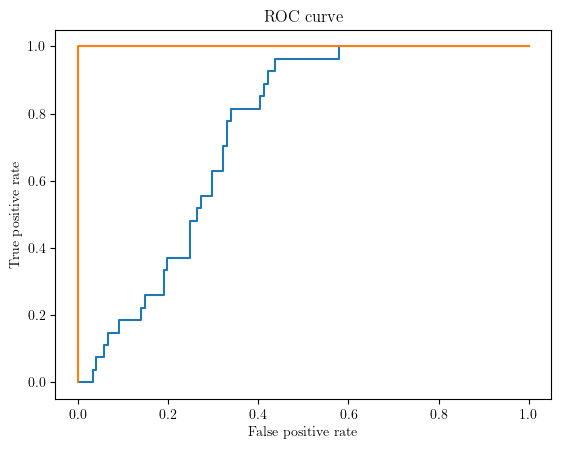

In [35]:

from sklearn.metrics import roc_auc_score

fpr, tpr, thresholds = roc_curve(Y_train, lr.predict_proba(X_train)[:, 1])
op_point = thresholds[np.argmax(tpr - fpr)] 
print(op_point)

print("Train accuracy: ", accuracy_score(Y_train, Y_train_pred))
print("Test accuracy: ", accuracy_score(Y_test, Y_test_pred))
print("Train precision: ", precision_score(Y_train, Y_train_pred))
print("Test precision: ", precision_score(Y_test, Y_test_pred))
print("Train recall: ", recall_score(Y_train, Y_train_pred))
print("Test recall: ", recall_score(Y_test, Y_test_pred))
print("Train R2: ", r2_score(Y_train, Y_train_pred))
print("Test R2: ", r2_score(Y_test, Y_test_pred))
print("Train AUC: ", roc_auc_score(Y_train, lr.predict_proba(X_train)[:, 1]))
print("Test AUC: ", roc_auc_score(Y_test, lr.predict_proba(X_test)[:, 1]))

print(Y_test, lr.predict_proba(X_test)[:, 1])

fig = plt.figure()
ax = fig.add_subplot(111)
r = roc_curve(Y_train, lr.predict_proba(X_train)[:, 1])
ax.plot(r[0], r[1], label="Train")
r = roc_curve(Y_test, lr.predict_proba(X_test)[:, 1])
ax.plot(r[0], r[1], label="Test")
ax.set_title("ROC curve")
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
plt.show()


In [14]:
print(confusion_matrix(Y_train, Y_train_pred))
print(confusion_matrix(Y_test, Y_test_pred))

[[81 40]
 [ 7 20]]
[[2 0]
 [3 2]]


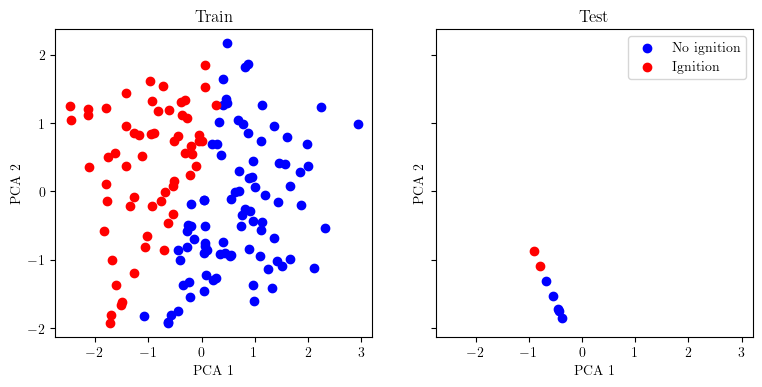

In [36]:
# Plot the predicted classes in 2D PCA space

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
ax = axs[0]
ax.set_title("Train")
ax.scatter(X_train_pca[Y_train_pred == 0, 0], X_train_pca[Y_train_pred == 0, 1], c='b', label='No ignition')
ax.scatter(X_train_pca[Y_train_pred == 1, 0], X_train_pca[Y_train_pred == 1, 1], c='r', label='Ignition')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")

ax = axs[1]
ax.set_title("Test")
ax.scatter(X_test_pca[Y_test_pred == 0, 0], X_test_pca[Y_test_pred == 0, 1], c='b', label='No ignition')
ax.scatter(X_test_pca[Y_test_pred == 1, 0], X_test_pca[Y_test_pred == 1, 1], c='r', label='Ignition')
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.legend()
plt.show()



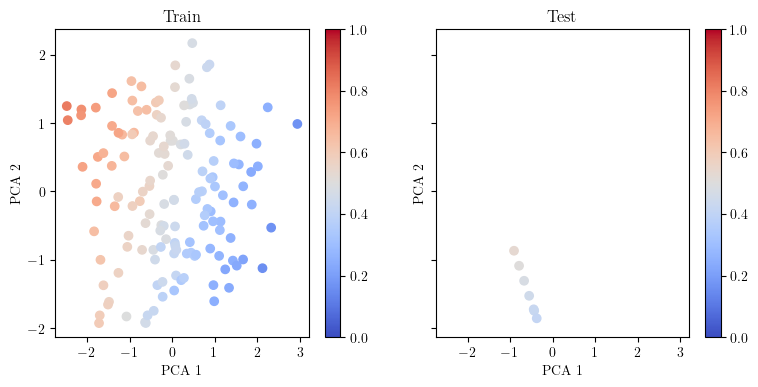

In [16]:
# Plot the predicted probablities in the same space

fig, axs = plt.subplots(1, 2, figsize=(9, 4), sharex=True, sharey=True)
ax = axs[0]
ax.set_title("Train")
c = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=lr.predict_proba(X_train)[:, 1], cmap='coolwarm', vmin=0, vmax=1)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.colorbar(c, ax=ax)

ax = axs[1]
ax.set_title("Test")
c = ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=lr.predict_proba(X_test)[:, 1], cmap='coolwarm', vmin=0, vmax=1)
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
plt.colorbar(c, ax=ax)
plt.show()



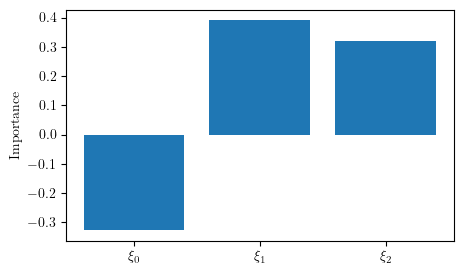

In [32]:
# Plot the importance of each feature
plt.figure(figsize=(5, 3))
plt.bar(np.arange(len(lr.coef_[0])), lr.coef_[0])
#plt.xlabel(r"Feature $\xi$")
plt.xticks(np.arange(len(lr.coef_[0])), [rf"$\xi_{i}$" for i in range(len(lr.coef_[0]))])
plt.ylabel("Importance")
plt.show()

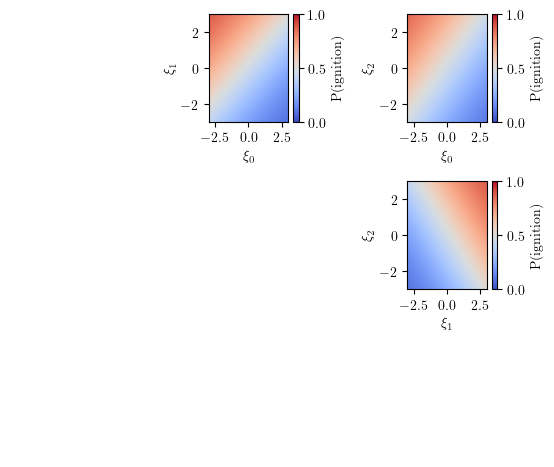

In [28]:
# For each pair of input coordinates, plot the decision boundary
fig, axs = plt.subplots(3, 3, figsize=(6, 5))
#fig.suptitle("Decision boundary projected to pairs of input dimensions")
cmap = plt.get_cmap('coolwarm')
norm = plt.Normalize(vmin=0, vmax=1)

# Visualise the decision boundary

for i in range(3):
    for j in range(i + 1, 3):
        ax = axs[i, j]
        ax.set_xlabel(rf"$\xi_{i}$")
        ax.set_ylabel(rf"$\xi_{j}$")
        
        xs, ys = np.meshgrid(np.linspace(-3, 3, 200), np.linspace(-3, 3, 200))
        zs = np.zeros_like(xs)
        arrs = [zs, zs, zs]
        arrs[i] = xs
        arrs[j] = ys
        input_coords = np.stack([arr.ravel() for arr in arrs], axis=1)
        ys = lr.predict_proba(input_coords)[:, 1]
        
        c = ax.scatter(input_coords[:, i], input_coords[:, j], c=ys, alpha=1, cmap=cmap, norm=norm, s=2)
        #c = ax.scatter(X_train[:, i], X_train[:, j], c=Y_train, cmap=cmap, norm=norm, s=10)
        ax.set_xlim(-3, 3)
        ax.set_ylim(-3, 3)
        cbar = plt.colorbar(c, ax=ax)
        cbar.set_label("P(ignition)")
        
        #ax.scatter([], [], c='b', label='No ignition')
        #ax.scatter([], [], c='r', label='Ignition')
        #ax.legend(loc='upper right')
        
fig.tight_layout()

# Hide the other axes
for i in range(3):
    for j in range(0, i+1):
        axs[i, j].axis('off')

plt.show()

# Repeat the same plot, but for training data

#fig, axs = plt.subplots(5, 5, figsize=(15, 14))
##fig.suptitle("Decision boundary for training data")
#for i in range(3):
#    for j in range(i + 1, 3):
#        ax = axs[i, j]
#        #ax.set_title(f"Decision boundary for input {i} and {j}")
#        ax.set_xlabel(rf"$\xi_{i}$")
#        ax.set_ylabel(rf"$\xi_{j}$")
#
#        c = ax.scatter(X_train[:, i], X_train[:, j], c=Y_train, cmap=cmap, norm=norm, s=10)
#        plt.colorbar(c, ax=ax)
#fig.tight_layout()
#
## Hide the other axes
#for i in range(5):
#    for j in range(0, i+1):
#        axs[i, j].axis('off')
#
#plt.show()
        